In [2]:
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import numpy as np
import odf
import math
import pdfkit
from scipy.stats import linregress
import scipy.constants as const
from itertools import chain
from statistics import mean
from uncertainties import ufloat, ufloat_fromstr
from uncertainties.umath import *
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, minimize_scalar
from lmfit.models import LorentzianModel
from IPython.display import display, Latex
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### calibration of magnetic field
- SI units. B is converted from $[mT]$ to $[T]$.

In [3]:
I = np.array([0, 0.4, 0.98, 1.67, 2.28, 3.22, 3.93, 4.54, 5.14, 5.48, 6.40, 6.92, 7.38, 7.86, 8.29, 9.16])
B = 10**(-3) * np.array([8, 30, 64, 105, 143, 200, 245, 283, 320, 342, 398, 428, 455, 489, 509,556])                  

ib = pd.DataFrame(list(zip(I, B)), columns=['I','B'])
ib.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
I,0.000,0.40,0.980,1.670,2.280,3.22,3.930,4.540,5.14,5.480,6.400,6.920,7.380,7.860,8.290,9.160
B,0.008,0.03,0.064,0.105,0.143,0.20,0.245,0.283,0.32,0.342,0.398,0.428,0.455,0.489,0.509,0.556


In [4]:
X = np.array(I).reshape(-1, 1)
Y = np.array(B).reshape(-1, 1)

reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_
coef = reg.coef_
reg_value = reg.score(X, Y)

def magnetic_field(I):
    return (coef[0, 0] * np.array(I) + intercept[0])

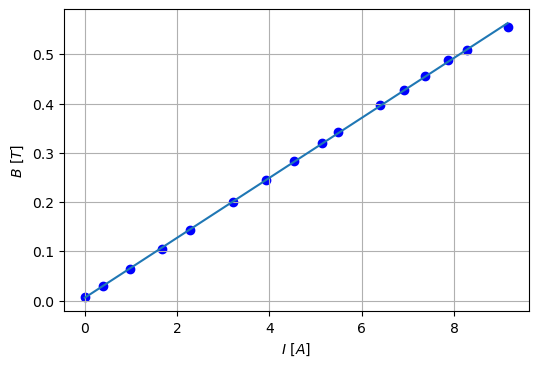

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [193]:
plt.figure(dpi=100)
plt.plot(X, magnetic_field(X))
plt.scatter(X, Y, color='b')
plt.xlabel('$I\ [A$]')
plt.ylabel('$B\ [T]$')
plt.grid()
plt.savefig('calibration.pdf')
plt.show()
display(Latex("$R^2$ = {}".format(reg_value)))
display(Latex("$f(x) = {}x + {}$".format(coef[0, 0], intercept[0])))

### calculation of Bohr magneton
- t, h, c, B are etalon spacing, Planck's constant, speed of light and array of magnetic fields respectively.
- All SI units. Ring positions are converted from $[mm]$ to $[m]$.

In [6]:
def radii(pos):
    """Returns consecutive radii starting with the outermost ring.
    Positions are taken from the leftmost to the rightmost rings."""
    
    n = len(pos)
    assert n % 16 == 0
    
    r = [abs(pos[n-1-i] - pos[i]) / 2 for i in range(n // 2)]
    return np.array(r)

def wave_num_diff(pos):
    """Returns the average difference in wave numbers of the two split wavelengths."""
    t = 3 * 10**(-3)
    
    r = radii(pos)
    r_sq = np.square(r)
    n_r = len(r)
    p_max = n_r // 2                    # maximum order of rings
    
    delta_sum = 0
    for i in range(n_r):
        delta_sum += (-1)**i * r_sq[i]
    avg_delta = delta_sum / p_max
    
    Delta_sum = 0
    for i in range(n_r):
        Delta_sum += (-1)**(i // 2) * r_sq[i] 
    avg_Delta = Delta_sum / p_max
    
    wave_num_diff = (1/(2 * t)) * (avg_delta/avg_Delta)
    return wave_num_diff

def bohr_magneton(I, pos):   
    h = const.h
    c = const.c
    
    B = magnetic_field(I)
    wave_num = wave_num_diff(pos)
    bohr_mag = (h * c) * (wave_num / (2 * B))
    
    return bohr_mag

In [93]:
# reading1 = [0.5, 0.9, 2.9, 3.5, 4.78, 5.54, 8.58, 9.60, 26.6, 27.64, 30.32, 31.06, 33.26, 33.82, 35.78, 36.36]
reading1 = [0.5, 0.9, 2.9, 3.5, 5.78, 6.54, 9.58, 10.60, 26.6, 27.64, 30.32, 31.06, 33.26, 33.82, 35.78, 36.36]
pos1 = np.array(reading1) / 2000

I1 = 6.05
u1 = bohr_magneton(I1, pos1)
u1

9.778206086879677e-24

In [94]:
# msd1 = [12, 13, 15, 15, 17, 18, 21, 22, 38, 39, 42, 43, 45, 45, 47, 48]
msd2 = [12, 13, 15, 15, 17, 18, 21, 22, 39, 40, 43, 44, 46, 46, 48, 49]
ssd2 = [80, 34, 22, 94, 96, 80, 80, 88, 30, 40, 52, 46, 10, 78, 82, 40]
pos2 = (np.array(msd2) + np.array(ssd2) / 100) / 2000

I2 = 7.15
u2 = bohr_magneton(I2, pos2)
u2

9.036506725801267e-24

In [86]:
# reading2b = [0.06, 0.68, 2.50, 3.2, 5.38, 6.08, 8.98, 10.14, 27.04, 28.32, 30.80, 31.60, 33.74, 34.48, 36.38, 36.92]
# pos2b = np.array(reading4) / 2000

# I2b = 7.06
# u2b = bohr_magneton(I4, pos4)
# u2b

In [95]:
# reading3 = [0.52, 0.96, 2.60, 3.34, 5.46, 6.28, 9, 10.46, 27, 28.32, 30.74, 31.68, 32.8, 33.58, 35.4, 35.9]
reading3 = [0.52, 0.96, 2.60, 3.34, 5.46, 6.28, 9, 10.46, 27, 28.32, 30.74, 31.68, 33.8, 34.58, 36.4, 36.9]
pos3 = np.array(reading3) / 2000

I3 = 7.97
u3 = bohr_magneton(I3, pos3)
u3

9.345774884818846e-24

In [96]:
# reading6 = [0.36, 0.94, 2.54, 3.34, 5.44, 6.4, 8.96, 10.4, 27.96, 29.56, 31.86, 32.78, 34.82, 35.74, 37.42, 38.08]
reading4 = [0.36, 0.94, 2.54, 3.34, 5.44, 6.4, 8.96, 10.4, 26.96, 28.56, 30.86, 31.78, 33.82, 34.74, 36.42, 37.08]
pos4 = np.array(reading4) / 2000

I4 = 9.07
u4 = bohr_magneton(I4, pos4)
u4

9.376530299923501e-24

In [98]:
# msd5 = [14, 15, 16, 17, 19, 20, 23, 24, 39, 40, 41, 42, 43, 44, 46, 47]
msd5 = [14, 15, 16, 17, 19, 20, 23, 24, 41, 43, 45, 46, 48, 49, 51, 52]
ssd5 = [54, 26, 88, 72, 66, 78, 36, 80, 80, 52, 84, 96, 80, 60, 34, 8]
pos5 = (np.array(msd5) + np.array(ssd5) / 100) / 2000

I5 = 10.13
u5 = bohr_magneton(I5, pos5)
u5

8.791066943159586e-24

In [67]:
# # reading7 = [0.74, 0.9, 3.16, 4, 5.94, 6.98, 9.6, 11.1, 27.7, 29.24, 31.64, 32.64, 34.56, 35.38, 37.18, 37.92]
# reading7 = [0.74, 1.4, 3.16, 4, 5.94, 6.98, 9.6, 11.1, 27.7, 29.24, 31.64, 32.64, 34.56, 35.38, 37.18, 37.92]
# pos7 = np.array(reading7) / 2000

# I7 = 10
# print(bohr_magneton(I7, pos7))

# u = np.mean([u1, u2, u3, u5, u6])
# print(u)

8.408546052969658e-24
9.267798852307363e-24


7.902611963437639e-24 7.719419859963611e-25


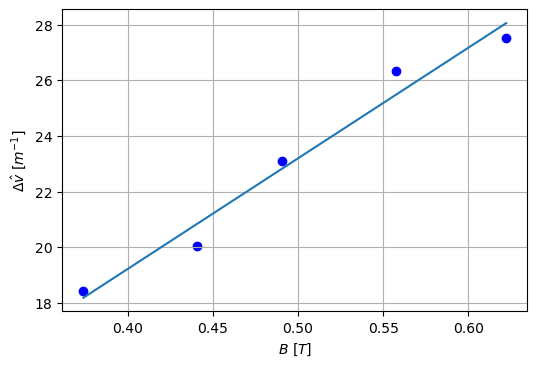

In [202]:
I_arr = np.array([I1, I2, I3, I4, I5])
B_arr = np.array([magnetic_field(I) for I in I_arr])

pos_arr = [pos1, pos2, pos3, pos4, pos5]
wave_num_arr = np.array([wave_num_diff(pos) for pos in pos_arr])
reg = linregress(B_arr, wave_num_arr / 2)
print(reg[0] * (const.h * const.c), reg[4] * (const.h * const.c))

plt.figure(dpi=100)
plt.scatter(B_arr, wave_num_arr/2, color='b')
plt.plot(B_arr, [reg[0] * B + reg[1] for B in B_arr])
plt.xlabel('$B\ [T]$')
plt.ylabel('$\Delta \hat v\ [m^{-1}]$')
plt.grid()
plt.savefig('linear_fit.pdf')
plt.show()

In [200]:
### from linear regression
u_reg = reg[0]
u_reg_err = reg[4]
print(u_reg, u_reg_err)

### from average
u_arr = np.array([u1, u2, u3, u5, u6])
u_avg = np.mean(u_arr)
u_avg_err = np.std(u_arr)
print(u_avg, u_avg_err)

### to LaTeX
r_arr = [1000 * radii(pos) for pos in [pos1, pos2, pos3, pos4, pos5]]
r_arr =  np.transpose(np.round(r_arr, 2))

u_arr_df = 10**(24) * u_arr
u_arr_df = np.array(u_arr_df, float)
u_arr_df = np.round(u_arr_df, 2)

data = np.array([I_arr, np.round(B_arr, 3), r_arr[0], r_arr[1], r_arr[2], r_arr[3], r_arr[4], 
                 r_arr[5], r_arr[6], r_arr[7], np.round(wave_num_arr, 1), u_arr_df])
df = pd.DataFrame(np.transpose(data),
                  columns=["$I [A]$", "$B [T]$", "$r_{4, a}$", "$r_{4, b}$", "$r_{3, a}$", "$r_{3, b}$", "$r_{2, a}$", 
                           "$r_{2, b}$", "$r_{1, a}$", "$r_{1, b}$", "$\Delta \hat v$", "$\mu_B$"])
df

39.78266981200264 3.8860459408861034
9.265616988116575e-24 3.3441408247182147e-25


,$I [A]$,$B [T]$,"$r_{4, a}$","$r_{4, b}$","$r_{3, a}$","$r_{3, b}$","$r_{2, a}$","$r_{2, b}$","$r_{1, a}$","$r_{1, b}$",$\Delta \hat v$,$\mu_B$
0,6.05,0.374,8.96,8.72,7.73,7.44,6.32,5.94,4.51,4.00,36.8,9.78
1,7.15,0.441,9.15,8.87,7.89,7.54,6.62,6.18,4.65,4.10,40.1,9.04
2,7.97,0.491,9.09,8.86,8.00,7.61,6.56,6.12,4.83,4.14,46.2,9.35
3,9.07,0.558,9.18,8.87,8.05,7.62,6.59,6.12,4.90,4.14,52.6,8.79
4,10.13,0.622,9.39,9.02,8.18,7.77,6.82,6.27,5.04,4.25,55.1,9.38


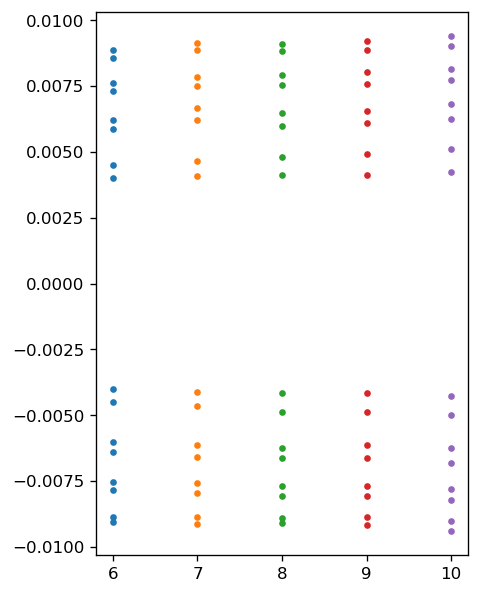

In [101]:
plt.figure(figsize=(4, 6), dpi=120)

plt.scatter([6]*16, pos1 - (pos1[7]+pos1[8])/2, marker='.')
plt.scatter([7]*16, pos2 - (pos2[7]+pos2[8])/2, marker='.')
# plt.scatter([7]*16, pos4 - (pos4[7]+pos4[8])/2, marker='.')
plt.scatter([8]*16, pos3 - (pos3[7]+pos3[8])/2, marker='.')
plt.scatter([9]*16, pos4 - (pos4[7]+pos4[8])/2, marker='.')

plt.scatter([10]*16, pos5 - (pos5[7]+pos5[8])/2, marker='.')
# plt.scatter([7]*16, pos7 - (pos7[7]+pos7[8])/2, marker='.')
plt.show()